In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import decimal
from decimal import *
import sys
import statistics 
import pandas as pd
from matplotlib.lines import Line2D
import time
from datetime import datetime
%matplotlib inline

plt.style.use('seaborn')

In [2]:
def extract_dataset(f):
    data = []
    for line in f:
        if (line.split()[0] == "1.0000"):
            data.append(line.split())
        elif(line.split()[0] == "5.0000"):
            data.append(line.split())

    #changing the values of 5.0000 to -1 and 1.0000 the value of 1
    df = pd.DataFrame(data)
    df[0] = df[0].replace(["1.0000","5.0000"],[1,-1])
    
    for col in df.columns:
        df[col] = df[col].astype(float)

    return df

In [3]:
def extract_features(df):
    rows, cols = df.shape
    features = np.zeros(shape = (rows,3))
    
    df1 = df.copy()
    df1 = df1.drop(0,axis=1)
    
    #extracting the intensity from the dataset
    for i in range(rows):
        mean_int = df1.loc[i,0:255].mean()
        features[i][0] = 1
        features[i][1] = mean_int
    

    flipped_df = df.loc[:, :1:-1]
    flipped_df.columns = df1.columns
    diff = pd.DataFrame()
    diff = abs(df1.subtract(flipped_df))
    
    #extracting the symmetry from the dataset
    for i in range(rows):
        mean_sym = diff.loc[i,0:255].mean()
        features[i][0] = 1
        features[i][2] =  mean_sym*-1

    return features, rows, cols

In [4]:
def plot_dataset(df, features, rows, cols):
    fig, ax = plt.subplots(figsize=(6,6)) 
#     fig, ax = plt.subplots(figsize=(10,10)) 
    plt.xlabel("Average Intensity")
    plt.ylabel("Symmetry")

    y = df[0]
    
    #plot the datapoints
    for i in range(rows):
        if(y[i] >= 0):
            ax.scatter(features[i][1], features[i][2], marker = 'x', color="royalblue", label = '1')
        else:   
            ax.scatter(features[i][1], features[i][2], marker = 'o', color ="firebrick", label = '5')

    ax.legend(('5', '1'), scatterpoints=1,loc='lower right', bbox_to_anchor=(1.17, 0.885), fontsize=10)
    
    return ax, features, y

In [5]:
def cal_classification_error(x, y, w):
    misclassified_pts = []
    
    #Evaluate whether the data points are classified based on the computed weights
    for i in range(len(x)):
        s = w.dot(x[i].transpose())

        if np.sign(s) != y[i]:
            misclassified_pts.append(i)
    
    #append the misclassified arrays for x and y
    train_x = [x[j] for j in misclassified_pts]
    train_y = [y[j] for j in misclassified_pts]
    
    e_in = len(misclassified_pts)/len(x)
    
    return e_in, len(misclassified_pts), train_x, train_y

In [6]:
def perceptron(x, y, hard_stop):
    w = np.array([0,0,0])
    iterations = 0
    train_x = x
    train_y = y
    acc = None
    ein_iters = []
 
    while iterations < hard_stop:
        #pick a point at random and compute its s = wTx.
        np.random.seed(100)
        idx = np.random.randint(0,len(train_x))
        s = w.dot(train_x[idx].transpose())
        
        #check for the signs, if doesn't match, update the weight
        if np.sign(s) != train_y[idx]:
            w = w + (train_y[idx] * train_x[idx])
            
        #calculate the new training data set(the misclassified points become the new training dataset).
        e_in, misclassified_pts, train_x, train_y = cal_classification_error(x,y,w)
        
        if misclassified_pts == 0:
            break   
            
        ein_iters.append(e_in)
        iterations += 1
        
    # plot all the in-sample errors
    fig, ax = plt.subplots(figsize=(15,4.5))
    plt.title("PLA | Ein Vs Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Ein")
    ax.plot([i for i in range(1, hard_stop)], [ein_iters[j] for j in range(1, hard_stop)])
    plt.show
        
    return w, iterations, e_in, misclassified_pts    

In [7]:
def pocket(x, y, hard_stop, f_trans = False):
    ein_iters = []
    iterations = 0
    train_x = x
    train_y = y
    mis_pocket = []
    
    if f_trans == True:
        w = np.array([0,0,0,0,0,0,0,0,0,0])
    else:
        w = np.array([0,0,0])

    best_error = 1
    w_pocket = w
    
    while iterations < hard_stop:
        #pick a point at random and compute its s = wTx.
        np.random.seed(100)
        idx = np.random.randint(0,len(train_x))
        
        s = w.dot(train_x[idx].transpose())
        
        #check for the signs, if doesn't match, update the weight
        if np.sign(s) != train_y[idx]:
            w = w + (train_y[idx] * train_x[idx])
            
        #calculate the new training data set(the misclassified points become the new training dataset).
        e_in, misclassified_pts, train_x, train_y = cal_classification_error(x,y,w)
        
        # in-sample errors for every iteration
        if e_in < best_error :
            w_pocket = w
            best_error = e_in
            mis_pocket = misclassified_pts
   
        #compute the error rate based on the number of misclassified points
        ein_iters.append(best_error)
        
        if best_error == 0:
            break 
        
        iterations += 1
    
    # plot all the in-sample errors
    fig, ax = plt.subplots(figsize=(15,4.5))
    plt.title("Pocket algorithm | Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Ein")
    ax.plot([i for i in range(1, hard_stop)], [ein_iters[j] for j in range(1, hard_stop)])
    plt.show
    
    return w_pocket, iterations, best_error, mis_pocket 

In [8]:
def feature_transform(x):
    z = np.empty([len(x), 10])
    
    for i in range(len(x)):

        z[i][0] = 1
        z[i][1] = x[i][1]
        z[i][2] = x[i][2]
        z[i][3] = (x[i][1])**2
        z[i][4] = x[i][1] * x[i][2]
        z[i][5] = (x[i][2])**2
        z[i][6] = (x[i][1])**3
        z[i][7] = (x[i][1]**2) * x[i][2]
        z[i][8] = x[i][1] * (x[i][2]**2)
        z[i][9] = (x[i][2])**3
        
    return z

In [9]:
def plot_boundary(x, w, ax, z = None, f_trans = False):    
    
    legend_elements = [Line2D([0],[0], color='green', lw=2, label='Final Hypothesis, g'),
                       Line2D([0], [0], marker='o', color='steelblue', label='y = +1',markersize=7),
                       Line2D([0], [0], marker='o', color='crimson', label='y = -1',markersize=7)]   
    if f_trans == False:
        x_axis_points = np.array(ax.get_xlim())
        
        #compute the slope and intercept for the final hypothesis
        final_slope = -1*(w[1]/w[2])  
        final_intercept = -1*(w[0]/w[2])
    
        #compute the final hypothesis
        y_pred = x_axis_points * final_slope + final_intercept
        
        #plot the final hypothesis
        ax.plot(x_axis_points,y_pred,color = 'green', Label = 'Final Hypothesis, g')
    
    else: 
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        delta = 0.005
        x1, x2 = np.meshgrid(np.arange(xmin, xmax, delta), np.arange(ymin, ymax, delta))
        y_pred = w[0]*1 + w[1]*(x1) + w[2]*(x2) + \
                             w[3]*(x1**2) + w[4]*(x1*x2) + w[5]*(x2**2) + \
                             w[6]*(x1**3) + w[7]*(x1**2*x2) + w[8]*(x1*x2**2) +  w[9]*(x2**3)
        ax.contour(x1,x2, y_pred, levels=[0], colors = ['green'])
    ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.5, 0.75), fontsize=10.5)

#### a. PLA on the preprocessed digits dataset for 1000 iterations

In-sample error: 0.03
Iterations = 1000
Total misclassified points: 54
Time taken for PLA: 0:00:21.195594


<function matplotlib.pyplot.show(*args, **kw)>

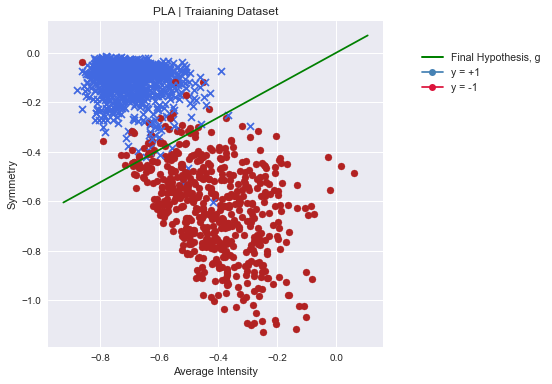

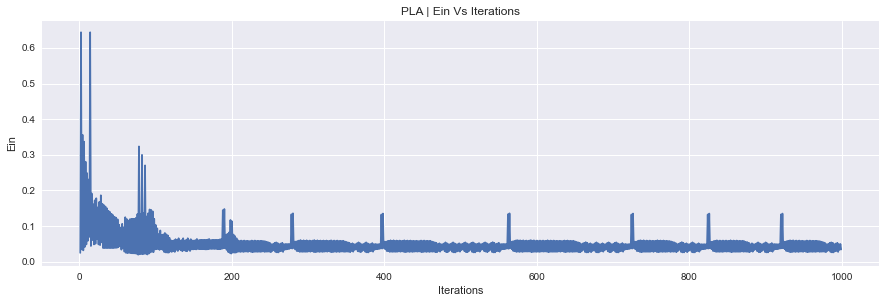

In [10]:
#Extracting features of the ZipDigits.train dataset
f_train = open("/Users/bharathi/Documents/Digits/ZipDigits.train", "r")
hard_stop = 1000

dataset_train = extract_dataset(f_train)
train_features, train_rows, train_cols = extract_features(dataset_train)
ax1, features, y_true = plot_dataset(dataset_train, train_features, train_rows, train_cols)
plt.title("PLA | Traianing Dataset")

start_time = datetime.now()
pla_w, iterations, e_in, misclassified_pts = perceptron(features, y_true, hard_stop)
total_time = datetime.now() - start_time
print("In-sample error: {}".format('%.2f'%(e_in)))
print("Iterations = {}".format(iterations))
print("Total misclassified points: {}".format(misclassified_pts))
print("Time taken for PLA: {}".format(total_time))
plot_boundary(features,pla_w, ax1)
plt.show

#### b. Pocket algorithm on the preprocessed digits dataset for 1000 iterations

In-sample error: 0.02
Iterations = 1000
Total misclassified points: 31
Time taken for the pocket algorithm: 0:00:21.963050


<function matplotlib.pyplot.show(*args, **kw)>

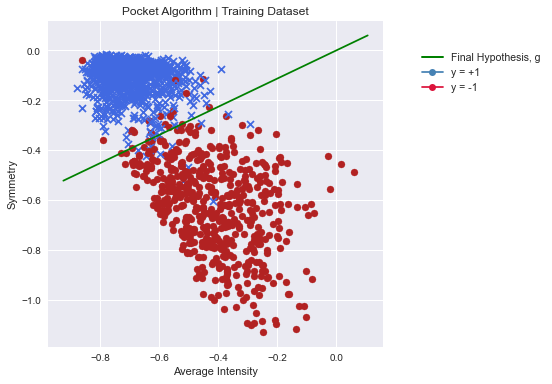

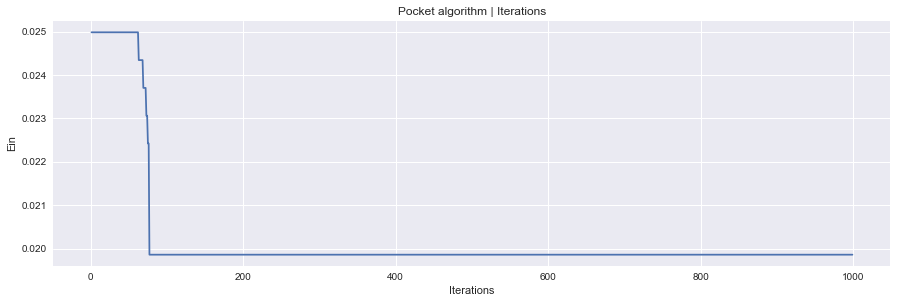

In [11]:
hard_stop = 1000

ax2, features, y_true = plot_dataset(dataset_train, train_features, train_rows, train_cols)
plt.title("Pocket Algorithm | Training Dataset")

start_time = datetime.now()
pocket_w, iterations, e_in_pocket, misclassified_pts = pocket(features, y_true, hard_stop)
total_time = datetime.now() - start_time
print("In-sample error: {}".format('%.2f'%(e_in_pocket)))
print("Iterations = {}".format(iterations))
print("Total misclassified points: {}".format(misclassified_pts))
print("Time taken for the pocket algorithm: {}".format(total_time))
plot_boundary(features, pocket_w, ax2)
plt.show

#### c. Error measure for PLA on the test dataset

Out-of-sample error: 0.04
Total misclassified points: 19


<function matplotlib.pyplot.show(*args, **kw)>

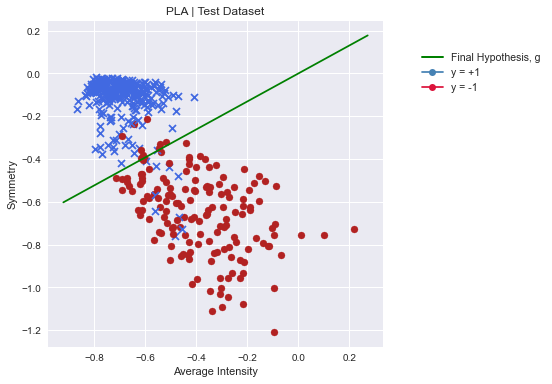

In [12]:
#Extracting features of the ZipDigits.test dataset
f_test = open("/Users/bharathi/Documents/Digits/ZipDigits.test", "r")
dataset_test = extract_dataset(f_test)
test_features, test_rows, test_cols = extract_features(dataset_test)
ax4, features, y_true = plot_dataset(dataset_test, test_features, test_rows, test_cols)
plt.title("PLA | Test Dataset")

e_in, misclassified_pts, train_x, train_y = cal_classification_error(test_features,y_true,pla_w)
print("Out-of-sample error: {}".format('%.2f'%(e_in)))
print("Total misclassified points: {}".format(misclassified_pts))
plot_boundary(features, pla_w, ax4)
plt.show

#### c. Error measure for Pocket algorithm on the test dataset

Out-of-sample error: 0.04
Total misclassified points: 16


<function matplotlib.pyplot.show(*args, **kw)>

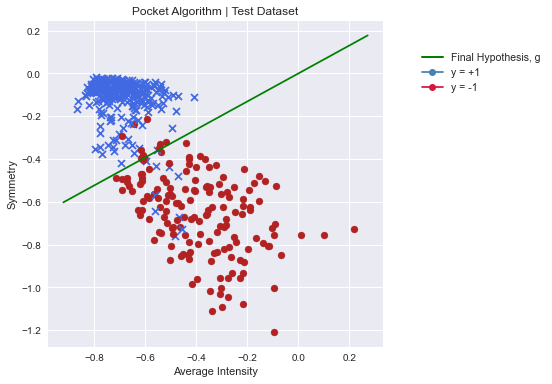

In [13]:
#Extracting features of the ZipDigits.test dataset
f_test = open("/Users/bharathi/Documents/Digits/ZipDigits.test", "r")
dataset_test = extract_dataset(f_test)
test_features, test_rows, test_cols = extract_features(dataset_test)
ax5, features, y_true = plot_dataset(dataset_test, test_features, test_rows, test_cols)
plt.title("Pocket Algorithm | Test Dataset")

e_in, misclassified_pts, train_x, train_y = cal_classification_error(test_features,y_true,pocket_w)
print("Out-of-sample error: {}".format('%.2f'%(e_in)))
print("Total misclassified points: {}".format(misclassified_pts))
plot_boundary(features, pla_w, ax5)
plt.show

The in-sample error for PLA is 0.03 whereas the in-sample error for Pocket algorithm is 0.02.
The test error for both PLA and pocket ia 0.04. 
Hence, digits out the sample can be generalized with a threshold of approximately ~0.02.

#### d. Feature transformation on train dataset using pocket algorithm for 1000 updates.

In-sample error: 0.02
Iterations = 1000
Total misclassified points: 32
Time taken for pocket algorithm: 0:00:22.018019


<function matplotlib.pyplot.show(*args, **kw)>

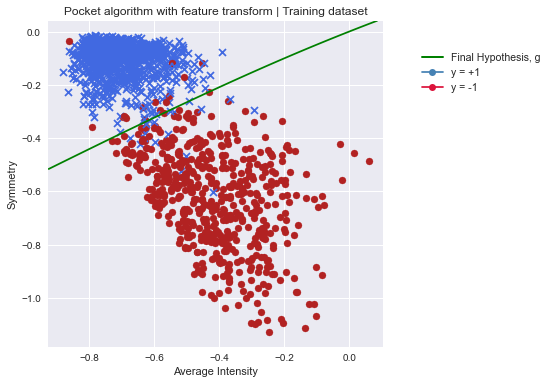

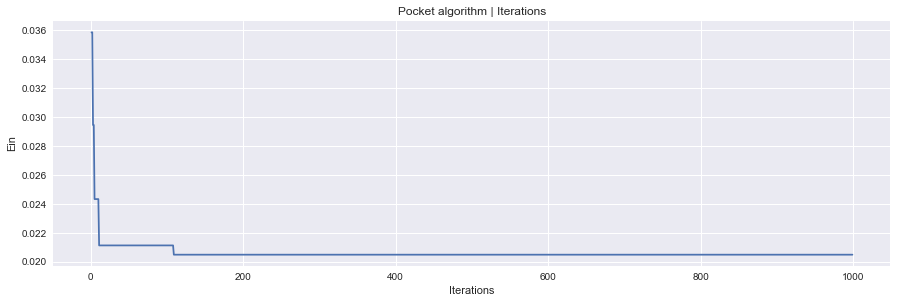

In [14]:
hard_stop = 1000

ax3, features, y_true = plot_dataset(dataset_train, train_features, train_rows, train_cols)
plt.title("Pocket algorithm with feature transform | Training dataset")
start_time = datetime.now()
z = feature_transform(features)
ft_w_pocket, ft_iterations, ft_e_in, ft_mis_pocket  = pocket(z, y_true, hard_stop, f_trans = True)
total_time = datetime.now() - start_time
print("In-sample error: {}".format('%.2f'%(ft_e_in)))
print("Iterations = {}".format(iterations))
print("Total misclassified points: {}".format(ft_mis_pocket))
print("Time taken for pocket algorithm: {}".format(total_time))
plot_boundary(features, ft_w_pocket, ax3, z, f_trans = True)
plt.show

#### e. Error measure for test dataset after feature transformation.

Out-of-sample error: 0.04
Total misclassified points: 17


<function matplotlib.pyplot.show(*args, **kw)>

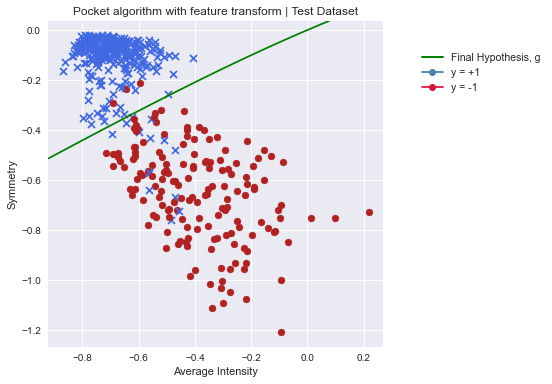

In [15]:
#Extracting features of the ZipDigits.test dataset
f_test = open("/Users/bharathi/Documents/Digits/ZipDigits.test", "r")
dataset_test = extract_dataset(f_test)
test_features, test_rows, test_cols = extract_features(dataset_test)
ax6, features, y_true = plot_dataset(dataset_test, test_features, test_rows, test_cols)
plt.title("Pocket algorithm with feature transform | Test Dataset")

z = feature_transform(features)
e_in, misclassified_pts, train_x, train_y = cal_classification_error(z,y_true,ft_w_pocket)
print("Out-of-sample error: {}".format('%.2f'%(e_in)))
print("Total misclassified points: {}".format(misclassified_pts))
plot_boundary(features, ft_w_pocket, ax6, z, f_trans = True)
plt.show